In [81]:
#Método para realizar o Boruta, e ao final, montar um DataFrame com a ordem selecionada pelo boruta

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder

def boruta_feature_order(data_path, target_column):
    # Carregar os dados do CSV
    D = pd.read_csv(data_path)
    variables = D.columns
    print(f'Lista de variáveis: {variables}')

    # Print para verificar os dados antes do processamento
    print("Dados antes do processamento:")
    print(D)
    tipo_antes = (type(D[target_column][0]))
    print(f'Tipo dos dados antes do processamento: {tipo_antes}')
    

    # Mapear os valores nominais para números inteiros únicos
    D_encoded = D.apply(LabelEncoder().fit_transform)
    # Print para verificar os dados após o processamento
    print("Dados após o processamento:")
    print(D_encoded)
    tipo_depois = (type(D_encoded[target_column][0]))
    print(f'Tipo dos dados após o processamento (inteiros): {tipo_depois}')

    # Separar os dados em características (X) e alvo (y)
    X = D_encoded.drop(columns=[target_column])
    y = D_encoded[target_column]

    # Inicializar um classificador Random Forest
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    # Inicializar o Boruta
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

    # Ajustar o Boruta aos dados
    boruta_selector.fit(X.values, y.values)
    print("Boruta inicializado com sucesso")

    # Obter as características selecionadas
    print("Variáveis na ordem inicial")
    print(variables)
    
    selected_features = X.columns[boruta_selector.support_]
    print("Features selecionadas")
    print(selected_features)
    # Obter as características não selecionadas
    unselected_features = X.columns[~boruta_selector.support_]
    print("Features não selecionadas")
    print(unselected_features)

    # Combinar características selecionadas e não selecionadas, ordenando-as pela ordem de ranking do Boruta
    all_features = [target_column] + list(selected_features) + list(unselected_features)
    print("Todas as features, incluindo a target: ")
    print(all_features)

    # Reorganizar o DataFrame original de acordo com a ordem das características selecionadas pelo Boruta
    df_reordered = D[all_features]
    
    # Salvar o DataFrame reordenado no formato CSV
    df_reordered.to_csv("data_reordered.csv", index=False)

    print("DataFrame reordenado salvo como data_reordered.csv")
    print("DataFrame criado na ordem das features selecionadas pelo Boruta")
    print(df_reordered)
    
    return all_features

# Caminho para o arquivo CSV e o nome da coluna alvo
data_path = "teste.csv"
target_column = "contact-lenses"

# Obter todas as características, incluindo a coluna alvo
all_features= boruta_feature_order(data_path, target_column)
print("Features em ordem")
print(all_features)

Lista de variáveis: Index(['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate',
       'contact-lenses'],
      dtype='object')
Dados antes do processamento:
               age spectacle-prescrip astigmatism tear-prod-rate  \
0            young              myope          no        reduced   
1            young              myope          no         normal   
2            young              myope         yes        reduced   
3            young              myope         yes         normal   
4            young       hypermetrope          no        reduced   
5            young       hypermetrope          no         normal   
6            young       hypermetrope         yes        reduced   
7            young       hypermetrope         yes         normal   
8   pre-presbyopic              myope          no        reduced   
9   pre-presbyopic              myope          no         normal   
10  pre-presbyopic              myope         yes        reduced   
11  pre-presbyopi

   contact-lenses astigmatism tear-prod-rate             age  \
0            none          no        reduced           young   
1            soft          no         normal           young   
2            none         yes        reduced           young   
3            hard         yes         normal           young   
4            none          no        reduced           young   
5            soft          no         normal           young   
6            none         yes        reduced           young   
7            hard         yes         normal           young   
8            none          no        reduced  pre-presbyopic   
9            soft          no         normal  pre-presbyopic   
10           none         yes        reduced  pre-presbyopic   
11           hard         yes         normal  pre-presbyopic   
12           none          no        reduced  pre-presbyopic   
13           soft          no         normal  pre-presbyopic   
14           none         yes        red

  0%|          | 0/1000000 [00:00<?, ?it/s]

Melhor modelo: DAG with 5 nodes and 2 edges
Valor do score K2: -98.72503647411929
Estrutura da rede: DAG with 5 nodes and 2 edges
CPDs: [<TabularCPD representing P(contact-lenses:3) at 0x1b5782e37d0>, <TabularCPD representing P(astigmatism:2 | contact-lenses:3) at 0x1b575095f50>, <TabularCPD representing P(tear-prod-rate:2 | contact-lenses:3) at 0x1b5782e1350>, <TabularCPD representing P(age:3) at 0x1b578274c10>, <TabularCPD representing P(spectacle-prescrip:2) at 0x1b578a05710>]
Bayesian Network: BayesianModel with 5 nodes and 2 edges


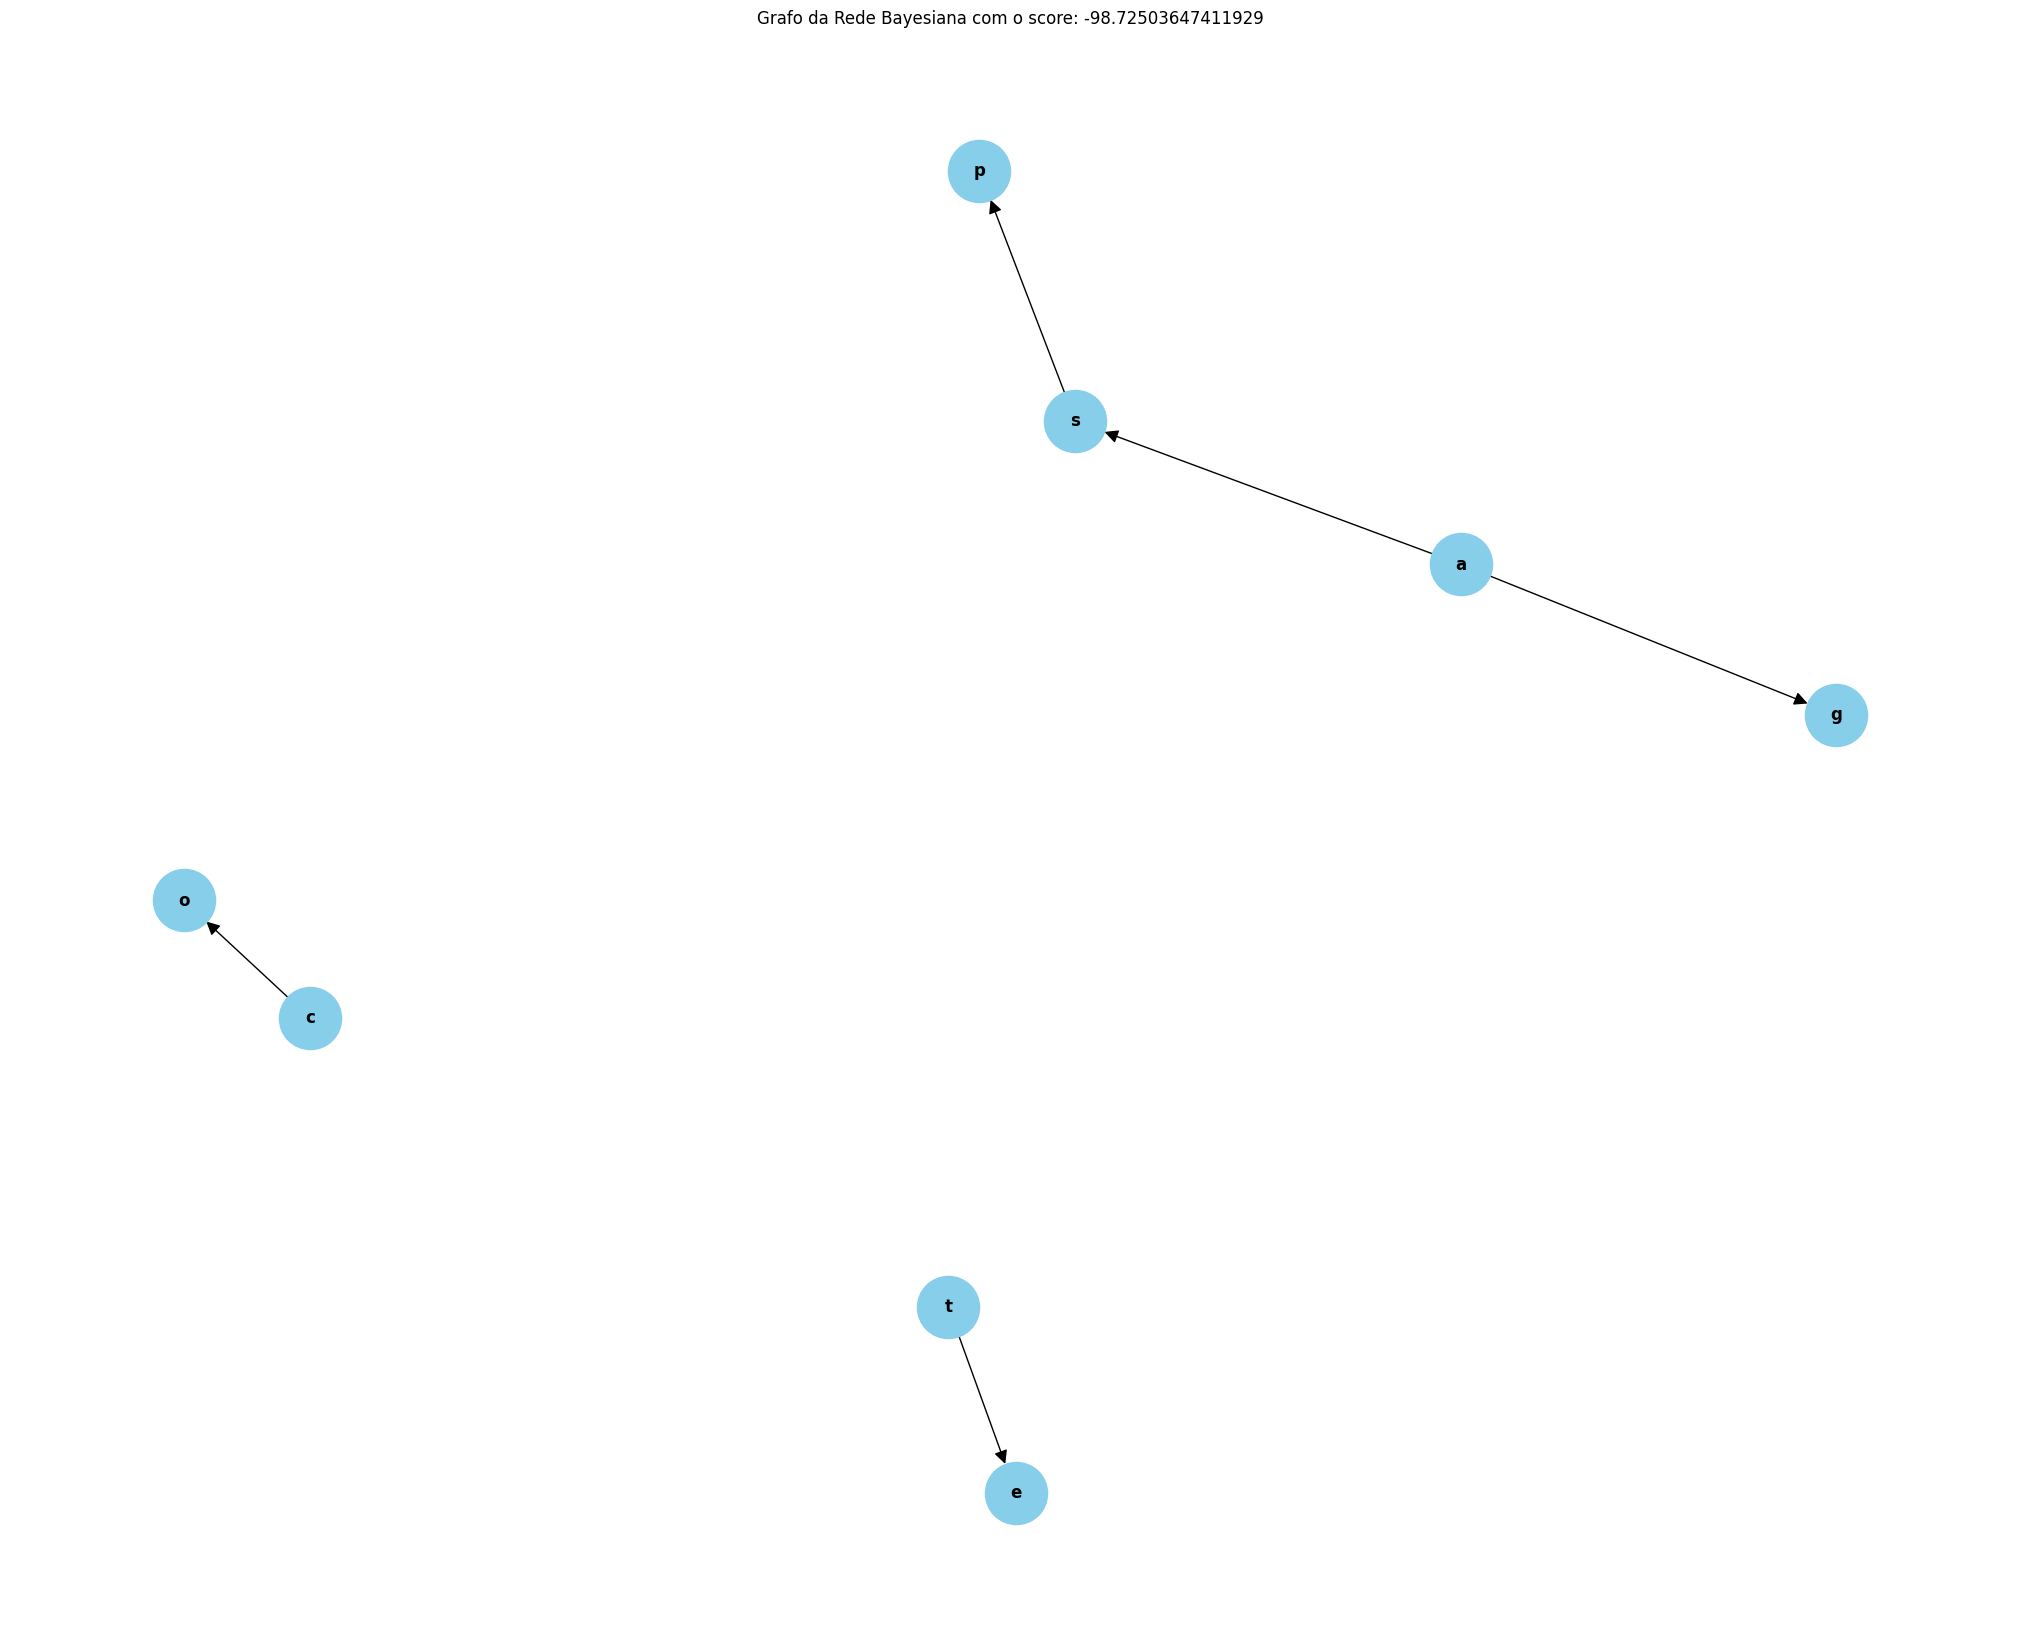

In [87]:
import pandas as pd
from pgmpy.estimators import K2Score
from sklearn.preprocessing import LabelEncoder
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, K2Score, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt

def load_data(DATA_CSV):
    D = pd.read_csv('data_reordered.csv')
    #D = D.apply(LabelEncoder().fit_transform)

    V = D.columns
    N = len(D.index)
    V_CARD = {v: len(D[v].unique()) for v in V}


    print(f'ARQUIVO: {D}')
    print(f'VARIÁVEIS: {V}')
    print(f'NÚMERO DE AMOSTRAS: {N}')
    print(f'MAPEAMENTO DAS VARIÁVEIS COM NÚMEROS DE VALORES ÚNICOS: {V_CARD}')
    return D, V, N, V_CARD

#Método K2 mais correto, que retorna as CPDs

def calcular_k2(D):
    """
    Calcula a pontuação K2 para os dados fornecidos.

    Args:
    - D: DataFrame contendo os dados.

    Returns:
    - k2score: Objeto K2Score contendo a pontuação K2 calculada.
    """
    k2score = K2Score(D)
    return k2score

def estimar_modelo(D, scoring_method):
    """
    Estima a estrutura do modelo usando o método K2.

    Args:
    - D: DataFrame contendo os dados.
    - scoring_method: Objeto de pontuação a ser usado para estimar a estrutura.

    Returns:
    - best_model: Modelo BayesianModel estimado.
    """
    estimator_k2 = HillClimbSearch(D)
    best_model = estimator_k2.estimate(scoring_method=scoring_method)
    return best_model

def tabular_cpd(best_model, D):
    """
    Estima as CPDs para o modelo usando o estimador bayesiano.

    Args:
    - best_model: Modelo BayesianModel estimado.
    - D: DataFrame contendo os dados.

    Returns:
    - cpds: Lista de CPDs estimadas.
    """
    bayesian_network = BayesianModel(best_model)
    estimator = BayesianEstimator(bayesian_network, D)
    cpds = []
    for node in bayesian_network.nodes():
        cpd = estimator.estimate_cpd(node)
        cpds.append(cpd)
    return cpds, bayesian_network

def desenhar_grafo(bayesian_network, k2_score):
    """
    Desenha o grafo da Rede Bayesiana.

    Args:
    - best_model: Modelo BayesianModel estimado.
    - k2_score: Valor do score K2 calculado.
    """
    graph = nx.DiGraph()
    # Convertendo as arestas para uma lista de tuplas
    edges = [(edge[0], edge[1]) for edge in bayesian_network.edges()]
    graph.add_edges_from(edges)
    plt.figure(figsize=(20, 16))
    nx.draw(graph, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
    plt.title(f'Grafo da Rede Bayesiana com o score: {k2_score}')
    plt.show()

# Dados já reordenados pelo Boruta, e suas propriedades
D = pd.read_csv('data_reordered.csv')
print(D)

V = D.columns
N = len(D.index)

print(f'VARIÁVEIS: {V}')
print(f'NÚMERO DE AMOSTRAS: {N}')

# Calcula a pontuação K2
k2score = calcular_k2(D)
print(k2score)
# Estima a estrutura do modelo com o K2
best_model = estimar_modelo(D, k2score)
print(f'Melhor modelo: {best_model}')

# Valor do Score gerado pelo K2
k2_score = k2score.score(best_model)
print(f'Valor do score K2: {k2_score}')

# Exibe a estrutura do modelo
structure = (best_model)
print(f'Estrutura da rede: {structure}')


# Estima as CPDs e passa a bayesian_netq
cpds, bayesian_network = tabular_cpd(best_model, D)
print(f'CPDs: {cpds}')
print(f'Bayesian Network: {bayesian_network}')
#Juntar o best_model com as cpds, para passar para o arquivoxml

# Desenha o grafo
desenhar_grafo(bayesian_network, k2_score)

In [85]:
from pgmpy.readwrite import XMLBIFWriter

# Inicialize o Modelo Bayesian
modelo_completo = BayesianModel(bayesian_network)  # Inicialize com as arestas do bayesian_network
print(f'Modelo: {modelo_completo}')

# Adicionando as CPDs ao Modelo
for cpd in cpds:
    modelo_completo.add_cpds(cpd)

# Verifique a consistência do modelo
assert modelo_completo.check_model()

# Verificar a Estrutura do Modelo
print("Estrutura do Modelo:")
print(modelo_completo.edges())

# Verificar as CPDs e imprimir na tela
print("\nCPDs do Modelo:")
for node in modelo_completo.nodes():
    print(f"CPD para o nó {node}:")
    print(modelo_completo.get_cpds(node))

# Verificar a Consistência do Modelo
print("\nVerificação de Consistência do Modelo:")
print(modelo_completo.check_model())

# Fazendo o formato XMLBIF
writer = XMLBIFWriter(modelo_completo)

# Especifique o nome do arquivo para salvar o modelo
nome_arquivo = "contact-lenses.xml"

# Escreva o modelo no arquivo .xmlbif
writer.write_xmlbif(nome_arquivo)  # Use write em vez de write_xmlbif


Modelo: BayesianModel with 5 nodes and 2 edges
Estrutura do Modelo:
[('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]

CPDs do Modelo:
CPD para o nó contact-lenses:
+----------------------+----------+
| contact-lenses(hard) | 0.195402 |
+----------------------+----------+
| contact-lenses(none) | 0.574713 |
+----------------------+----------+
| contact-lenses(soft) | 0.229885 |
+----------------------+----------+
CPD para o nó astigmatism:
+------------------+-----+----------------------+
| contact-lenses   | ... | contact-lenses(soft) |
+------------------+-----+----------------------+
| astigmatism(no)  | ... | 0.875                |
+------------------+-----+----------------------+
| astigmatism(yes) | ... | 0.12500000000000003  |
+------------------+-----+----------------------+
CPD para o nó tear-prod-rate:
+-------------------------+-----+----------------------+
| contact-lenses          | ... | contact-lenses(soft) |
+-------------------------+-----+-----

In [ ]:
'''def exportar_xmlbif(best_model, cpds, nome_arquivo, all_nodes, all_values):
    """
    Exporta o modelo e as CPDs para um arquivo no formato XMLBIF.

    Args:
    - best_model: Modelo BayesianModel estimado.
    - cpds: Lista de CPDs estimadas.
    - nome_arquivo: Nome do arquivo XMLBIF a ser gerado.
    - all_nodes: Todos os nós do dataset, mesmo aqueles que não estão conectados no modelo.
    - all_values: Todos os valores possíveis para cada nó do dataset.
    """
    with open(nome_arquivo, 'w') as f:
        f.write('<?xml version="1.0"?>\n')
        f.write('<!-- DTD for the XMLBIF 0.3 format -->\n')
        f.write('<!DOCTYPE BIF [\n')
        f.write('<!ELEMENT BIF ( NETWORK )*>\n')
        f.write('<!ATTLIST BIF VERSION CDATA #REQUIRED>\n')
        f.write('<!ELEMENT NETWORK ( NAME, ( PROPERTY | VARIABLE | DEFINITION )* )>\n')
        f.write('<!ELEMENT NAME (#PCDATA)>\n')
        f.write('<!ELEMENT VARIABLE ( NAME, ( OUTCOME |  PROPERTY )* ) >\n')
        f.write('<!ATTLIST VARIABLE TYPE (nature|decision|utility) "nature">\n')
        f.write('<!ELEMENT OUTCOME (#PCDATA)>\n')
        f.write('<!ELEMENT DEFINITION ( FOR | GIVEN | TABLE | PROPERTY )* >\n')
        f.write('<!ELEMENT FOR (#PCDATA)>\n')
        f.write('<!ELEMENT GIVEN (#PCDATA)>\n')
        f.write('<!ELEMENT TABLE (#PCDATA)>\n')
        f.write('<!ELEMENT PROPERTY (#PCDATA)>\n')
        f.write(']>\n')
        f.write('\n')
        f.write('<BIF VERSION="0.3">\n')
        f.write('<NETWORK>\n')
        
        # Escreve todos os nós do dataset
        for i, node in enumerate(all_nodes):
            f.write('<VARIABLE TYPE="nature">\n')
            f.write(f'<NAME>{node}</NAME>\n')
            if i == 0:
                continue  # Pula a lista de valores para a primeira variável
            for value in all_values[node]:
                f.write(f'<OUTCOME>{value}</OUTCOME>\n')
            f.write('</VARIABLE>\n')
        
        # Escreve os valores da primeira variável no final
        #ESTA DANDO ERRO NA PRIMEIRA VARIÁVEL, POIS ELA IMPRIME UM VARIABLE TYPE A MAIS (SOLUÇÃO: APAGAR A PRIMEIRA VARIABLE TYPE DO XML GERADO)
        first_node = all_nodes[0]
        f.write('<VARIABLE TYPE="nature">\n')
        f.write(f'<NAME>{first_node}</NAME>\n')
        for value in all_values[first_node]:
            f.write(f'<OUTCOME>{value}</OUTCOME>\n')
        f.write('</VARIABLE>\n')
        
        # Escreve as variáveis que não possuem CPD
        for node in all_nodes:
            if node not in {cpd.variable for cpd in cpds}:
                f.write('<DEFINITION>\n')
                f.write(f'<FOR>{node}</FOR>\n')
                f.write('<TABLE>\n')
                num_outcomes = len(all_values[node])
                for _ in range(num_outcomes):
                    f.write(' '.join(['0.33'] * num_outcomes))  # Valor constante entre 0 e 1
                    f.write('\n')
                f.write('</TABLE>\n')
                f.write('</DEFINITION>\n')
                
        # Escreve as CPDs para as variáveis que possuem CPD
        for cpd in cpds:
            f.write('<DEFINITION>\n')
            f.write(f'<FOR>{cpd.variable}</FOR>\n')
            parents = ' '.join(cpd.variables[1:])
            if parents:
                f.write(f'<GIVEN>{parents}</GIVEN>\n')
            f.write('<TABLE>\n')
            f.write(' '.join(map(str, cpd.values.flatten())))
            f.write('\n')
            f.write('</TABLE>\n')
            f.write('</DEFINITION>\n')
                
        f.write('</NETWORK>\n')
        f.write('</BIF>\n')

# Lista de todos os nós do dataset
all_nodes = D.columns.tolist()

# Dicionário com todos os valores possíveis para cada nó
all_values = {node: sorted(set(D[node])) for node in all_nodes}

# Exporta para XMLBIF
exportar_xmlbif(best_model, cpds, 'modelo.xml', all_nodes, all_values)'''


'def exportar_xmlbif(best_model, cpds, nome_arquivo, all_nodes, all_values):\n    """\n    Exporta o modelo e as CPDs para um arquivo no formato XMLBIF.\n\n    Args:\n    - best_model: Modelo BayesianModel estimado.\n    - cpds: Lista de CPDs estimadas.\n    - nome_arquivo: Nome do arquivo XMLBIF a ser gerado.\n    - all_nodes: Todos os nós do dataset, mesmo aqueles que não estão conectados no modelo.\n    - all_values: Todos os valores possíveis para cada nó do dataset.\n    """\n    with open(nome_arquivo, \'w\') as f:\n        f.write(\'<?xml version="1.0"?>\n\')\n        f.write(\'<!-- DTD for the XMLBIF 0.3 format -->\n\')\n        f.write(\'<!DOCTYPE BIF [\n\')\n        f.write(\'<!ELEMENT BIF ( NETWORK )*>\n\')\n        f.write(\'<!ATTLIST BIF VERSION CDATA #REQUIRED>\n\')\n        f.write(\'<!ELEMENT NETWORK ( NAME, ( PROPERTY | VARIABLE | DEFINITION )* )>\n\')\n        f.write(\'<!ELEMENT NAME (#PCDATA)>\n\')\n        f.write(\'<!ELEMENT VARIABLE ( NAME, ( OUTCOME |  PROPERTY 

In [ ]:
#Método inicial do Boruta, sem gerar um dataframe 

'''import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder

def boruta_feature_ranking(data_path, target_column):
    # Carregar os dados do CSV
    D = pd.read_csv(data_path)
    variables = D.columns
    print(f'Lista de variáveis: {variables}')

    # Print para verificar os dados antes do processamento
    print("Dados antes do processamento:")
    print(D)
    tipo_antes = (type(D[target_column][0]))
    print(f'Tipo dos dados antes do processamento: {tipo_antes}')
    

    # Mapear os valores nominais para números inteiros únicos
    D_encoded = D.apply(LabelEncoder().fit_transform)
    # Print para verificar os dados após o processamento
    print("Dados após o processamento:")
    print(D_encoded)
    tipo_depois = (type(D_encoded[target_column][0]))
    print(f'Tipo dos dados após o processamento (inteiros): {tipo_depois}')

    # Separar os dados em características (X) e alvo (y)
    X = D_encoded.drop(columns=[target_column])
    y = D_encoded[target_column]

    # Inicializar um classificador Random Forest
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    # Inicializar o Boruta
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

    # Ajustar o Boruta aos dados
    boruta_selector.fit(X.values, y.values)
    print("Boruta inicializado com sucesso")

# Obter as características selecionadas
    print("Variáveis na ordem inicial")
    print(variables)
    
    selected_features = X.columns[boruta_selector.support_]
    print("Features selecionadas")
    print(selected_features)
    # Obter as características não selecionadas
    unselected_features = X.columns[~boruta_selector.support_]
    print("Features não selecionadas")
    print(unselected_features)

    # Combinar características selecionadas e não selecionadas, ordenando-as pela ordem de ranking do Boruta
    all_features = [target_column] + list(selected_features) + list(unselected_features)
    print("Todas as features, incluindo a target: ")
    print(all_features)


    # Retornar a ordem das características
    return all_features



# Caminho para o arquivo CSV e o nome da coluna alvo
data_path = "teste.csv"
target_column = "contact-lenses"

# Obter todas as características, incluindo a coluna alvo
all_features = boruta_feature_ranking(data_path, target_column)
print("Todas as características, incluindo a coluna alvo no início:")
print(all_features)'''




'import pandas as pd\nfrom sklearn.ensemble import RandomForestClassifier\nfrom boruta import BorutaPy\nfrom sklearn.preprocessing import LabelEncoder\n\ndef boruta_feature_ranking(data_path, target_column):\n    # Carregar os dados do CSV\n    D = pd.read_csv(data_path)\n    variables = D.columns\n    print(f\'Lista de variáveis: {variables}\')\n\n    # Print para verificar os dados antes do processamento\n    print("Dados antes do processamento:")\n    print(D)\n    tipo_antes = (type(D[target_column][0]))\n    print(f\'Tipo dos dados antes do processamento: {tipo_antes}\')\n    \n\n    # Mapear os valores nominais para números inteiros únicos\n    D_encoded = D.apply(LabelEncoder().fit_transform)\n    # Print para verificar os dados após o processamento\n    print("Dados após o processamento:")\n    print(D_encoded)\n    tipo_depois = (type(D_encoded[target_column][0]))\n    print(f\'Tipo dos dados após o processamento (inteiros): {tipo_depois}\')\n\n    # Separar os dados em caract